In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

import numpy as np
from sklearn.metrics import confusion_matrix

import os
import pandas as pd
import time
import warnings
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

from joblib import dump, load

import librosa
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print(f"Using device: {device}")

warnings.filterwarnings('ignore')

Using device: cuda


In [111]:
# Scale data based on the overall dataset
complete_features = pd.read_csv("./anech_esc50_features_normalized.csv")
complete_features = complete_features.iloc[:,2:]
scaler = StandardScaler()
minmax = MinMaxScaler()
robust = RobustScaler()
scaler.fit(complete_features)
minmax.fit(complete_features)
robust.fit(complete_features)

dump(scaler, 'StandardScaler.joblib')
dump(minmax, 'MinMaxScaler.joblib')
dump(robust, 'RobustScaler.joblib')

['RobustScaler.joblib']

In [112]:
# Scale spectrograms in batchs based on the overall dataset
directory = "./Anechoic_ESC50_spectrograms"
means = []
variances = []
medians = []
iqr_list = []
min_vals = []
max_vals = []
batch_size = 1000

all_filenames = [filename for filename in os.listdir(directory) if filename.endswith('.pt')]


for filename in tqdm(all_filenames):
    file_path = os.path.join(directory, filename)
    tensor = torch.load(file_path)
    data = tensor.numpy().flatten()
    data[np.isnan(data)] = 0 
    
    # Batch processing
    for i in range(0, len(data), batch_size):
        batch = data[i:i + batch_size]
        means.append(np.mean(batch))
        variances.append(np.var(batch))
        medians.append(np.median(batch))
        q75, q25 = np.percentile(batch, [75, 25])
        iqr_list.append(q75 - q25)
        min_vals.append(np.min(batch))
        max_vals.append(np.max(batch))

# Aggregate statistics
mean = np.mean(means)
scale_std = np.sqrt(np.mean(variances))
median = np.median(medians)
iqr = np.median(iqr_list)
min_val = np.min(min_vals)
max_val = np.max(max_vals)

scalerSpect = StandardScaler()
scalerSpect.mean_ = np.array([mean])
scalerSpect.scale_ = np.array([scale_std])

robustSpect = RobustScaler()
robustSpect.center_ = np.array([median])
robustSpect.scale_ = np.array([iqr])

minmaxSpect = MinMaxScaler()
minmaxSpect.min_ = np.array([min_val])
minmaxSpect.scale_ = np.array([1/(max_val - min_val)])


dump(scalerSpect, 'StandardScalerSpect.joblib')
dump(minmaxSpect, 'MinMaxScalerSpect.joblib')
dump(robustSpect, 'RobustScalerSpect.joblib')

 48%|████▊     | 9275/19256 [05:41<06:19, 26.30it/s]

In [ ]:
scalerSpect = load("./StandardScalerSpect.joblib")
print(scalerSpect.mean_, scalerSpect.scale_)

[-0.39753428] [0.21884337]


In [ ]:

class AnechoicDataset(Dataset):
    def __init__(self, csv_file, spectrogram_dir, transform=None, target_transform=None):
        self.df = pd.read_csv(csv_file)
        self.spectrograms = spectrogram_dir
        self.transform = transform
        self.target_transform = target_transform
        self.label_map = {
            'Drone': 0,
            'No Drone': 1
        }

        self.scaler = load("./StandardScaler.joblib")
        self.robust = load("./RobustScaler.joblib")
        self.minmax = load("./MinMaxScaler.joblib")
        self.scalerSpect = load("./StandardScalerSpect.joblib")
        self.robustSpect = load("./RobustScalerSpect.joblib")
        self.minmaxSpect = load("./MinMaxScalerSpect.joblib")


    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        features = torch.FloatTensor(self.df.iloc[idx, 2:])
        features = features.unsqueeze(dim=0)
        features = self.scaler.transform(features)
        features = self.minmax.transform(features)
        features = self.robust.transform(features)
        features = features.squeeze()

        
        spectrogram_filename = f"{self.df.iloc[idx, 0].split('\\')[-1][0:-4]}_spectrogram.pt"
        spectrogram_path = os.path.join(self.spectrograms, spectrogram_filename)
        spectrogram = torch.load(spectrogram_path)
        spectrogram = torch.nan_to_num(spectrogram)
        spectrogram = np.array(spectrogram)
        spectrogram_flat = spectrogram.reshape(-1, spectrogram.shape[-1])
        spectrogram_flat = self.scalerSpect.transform(spectrogram_flat)
        spectrogram_flat = self.robustSpect.transform(spectrogram_flat)
        spectrogram_flat = self.minmaxSpect.transform(spectrogram_flat)
        spectrogram = spectrogram_flat.reshape(spectrogram.shape)
        spectrogram = torch.nan_to_num(torch.from_numpy(spectrogram))

        label = self.df.iloc[idx, 1]
        
        if self.target_transform:
            label = self.target_transform(label)
        

        return torch.FloatTensor(spectrogram), torch.FloatTensor(features), torch.tensor(label)
    

# Usage example
csv_file = "./anech_esc50_features_normalized.csv"
spectrogram_dir = "./Anechoic_ESC50_spectrograms"

# Define any transformations if needed
transform = None
target_transform = None

combined_dataset = AnechoicDataset(csv_file, spectrogram_dir, transform=transform, target_transform=target_transform)

In [24]:
class EscapeDataset(Dataset):
    def __init__(self, csv_file, spectrogram_dir, transform=None, target_transform=None):
        self.df = pd.read_csv(csv_file)
        self.spectrograms = spectrogram_dir
        self.transform = transform
        self.target_transform = target_transform
        self.label_map = {
            'Drone': 0,
            'No Drone': 1
        }

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Dataset has no label
        if torch.is_tensor(idx):
            idx = idx.tolist()

        features = torch.FloatTensor(self.df.iloc[idx, 1:])
        filename = self.df.iloc[idx, 0][0:-4]
        spectrogram_filename = f"{filename}_spectrogram.pt"
        spectrogram_path = os.path.join(self.spectrograms, spectrogram_filename)
        spectrogram = torch.load(spectrogram_path)
        spectrogram = torch.nan_to_num(spectrogram)
        
        return filename, torch.tensor(spectrogram), torch.tensor(features)

# Usage example
csv_file = ".//ESCAPEII_mfccs_d1_d2_normalized.csv"
spectrogram_dir = "C:\\Users/Alec/Desktop/ESCAPEII_d306_d308_spectrograms"

# Define any transformations if needed
transform = None
target_transform = None

escape_dataset = EscapeDataset(csv_file, spectrogram_dir, transform=transform, target_transform=target_transform)
escape_loader = DataLoader(
    escape_dataset,
    batch_size=64,
    shuffle=False
)

In [ ]:
train_size = int(.8 * len(combined_dataset))
test_size = int(.75 * (len(combined_dataset) - train_size))
val_size = len(combined_dataset) - train_size - test_size

train_dataset, test_dataset, val_dataset = torch.utils.data.random_split(combined_dataset, [train_size, test_size, val_size])
print(train_dataset)
print(train_dataset[0])

train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True
    )

test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=64,
    shuffle=False
)

(tensor([[[ 3.2811, -3.8625,  2.1927,  ...,  4.4446,  3.6910,  5.5754],
         [ 5.0738,  4.5284,  4.5311,  ...,  6.9914,  6.3246,  4.0594],
         [ 6.0439,  6.1635,  5.2640,  ...,  9.0586,  7.6254,  5.1689],
         ...,
         [-6.8819, -6.8819, -6.8819,  ..., -6.8819, -6.8819, -6.0313],
         [-6.8819, -6.8819, -6.8819,  ..., -6.8819, -6.8819, -6.0214],
         [-6.8819, -6.8819, -6.8819,  ..., -6.8819, -6.8819, -6.0091]]]), tensor([0.9656, 0.8378, 1.1303,  ..., 0.4776, 0.4776, 0.4776]), tensor(1))


In [98]:
for spectrogram, feature, label in train_loader:
    if spectrogram.mean() != 0:
        print(spectrogram)

tensor([[[[ 8.9706e+00,  1.1429e+01,  1.2101e+01,  ...,  3.8704e+00,
            9.7336e+00,  1.0100e+01],
          [ 8.5600e+00,  1.0269e+01,  1.0830e+01,  ...,  7.8934e+00,
            9.7032e+00,  9.7492e+00],
          [ 7.2242e+00,  6.2309e+00,  7.1906e+00,  ...,  5.8378e+00,
            7.9578e+00,  8.6439e+00],
          ...,
          [ 5.0192e+00,  3.0597e+00, -2.8147e+00,  ..., -6.8819e+00,
           -6.8819e+00, -5.2895e+00],
          [ 5.0230e+00,  3.4464e+00, -1.8843e+00,  ..., -6.8819e+00,
           -6.8819e+00, -5.2431e+00],
          [ 5.0116e+00,  2.9666e+00, -7.8207e-01,  ..., -6.8819e+00,
           -6.8819e+00, -5.2355e+00]]],


        [[[ 1.0265e+01,  1.1454e+01, -6.0814e-01,  ...,  9.1651e+00,
            3.2906e+00,  5.1628e+00],
          [ 9.6732e+00,  1.0941e+01,  1.1356e+01,  ...,  9.6989e+00,
            8.3755e+00,  6.4567e+00],
          [ 7.9400e+00,  8.0322e+00,  1.0438e+01,  ...,  8.0322e+00,
            9.1722e+00,  7.2803e+00],
          ...,
   

KeyboardInterrupt: 

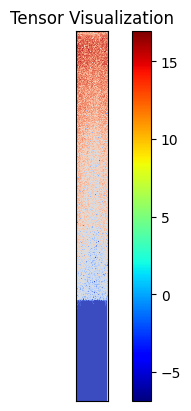

In [ ]:
i = 40000
tensor = train_dataset[i][0][0]
plt.imshow(tensor, cmap='jet')
plt.title('Tensor Visualization')
plt.colorbar()

librosa.display.specshow(train_dataset[i][0][0].numpy())
plt.show()

In [ ]:
class Ensemble(nn.Module):
    def __init__(self, CNN, LNN):
        super().__init__()
        self.cnn = CNN
        self.lnn = LNN
        self.classifier = nn.Linear(2, 1)

    def forward(self, spectrograms, features):
        spectrogram_preds = self.cnn(spectrograms)
        feature_preds = self.lnn(features)
        combined_preds = torch.stack((spectrogram_preds, feature_preds), dim=1)
        preds = self.classifier(combined_preds).squeeze(dim=1)
        return preds

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            nn.LazyConv2d(4, 5, stride=2),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.LazyConv2d(8, 5, stride=2),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.LazyConv2d(8, 5, stride=2),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=2),

            # Linear perceptron for classification
            nn.Flatten(),
            nn.LazyLinear(1024),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(1024),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(256),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(1)
    )

    def forward(self, x):
        logits = self.seq(x).squeeze(dim=1)
        return logits

class LNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            nn.LazyLinear(4096),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(4096),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(1024),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(1024),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(512),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(256),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(1)
        )

    def forward(self, x):
        logits = self.seq(x).squeeze(dim=1)
        return logits


In [ ]:
def split_seconds(seconds):
    minutes = seconds // 60
    hours = minutes // 60
    days = hours // 24
    return seconds % 60, minutes % 60, hours % 24, days


In [ ]:
def main():
    # Define model
    convolutional = CNN()
    # conv_state = torch.load("./dnd_spectrogram_models\\_epoch_13.pt")
    # convolutional.load_state_dict(conv_state)
    linear = LNN()
    # lin_state = torch.load("./dnd_mfcc_models_normalized\\_epoch_63.pt")
    # linear.load_state_dict(lin_state)
    model = Ensemble(convolutional, linear)

    # Cuda setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #device = torch.device("cpu")
    
    # Define models
    model = model.to(device)
   
    print(f"Using device: {device}")
    # Optimizer setup
    optimizer = Adam(model.parameters(), lr=1e-4)
   
    # Loss function
    loss_fn = nn.BCEWithLogitsLoss(reduction="mean")
   
    # Number of epochs
    num_epochs = 64
   
    # Train or load model?
    print("Training model....")
    start = time.time()
    for epoch in tqdm(range(num_epochs), desc="Epochs"):
        
        model.train()
        for batch_idx, (spectrograms, features, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)):
            spectrograms, features, labels = spectrograms.to(device), features.to(device), labels.to(device)
            optimizer.zero_grad()
           
            # Ensemble forward pass
            logits = model(spectrograms, features)
            loss = loss_fn(logits, labels.to(float))
            loss.backward()
            optimizer.step()

        model.eval()
        num_test = 0
        num_correct = 0
        total_loss = 0
        with torch.no_grad():
            for spectrograms, features, labels in tqdm(test_loader, desc="Testing"):
                spectrograms, features, labels = spectrograms.to(device), features.to(device), labels.to(device)
                logits = model(spectrograms, features)
                loss = loss_fn(logits, labels.to(float))
                total_loss += loss.item()
                preds = torch.round(torch.sigmoid(logits))
                num_test += labels.size(0)
                num_correct += preds.eq(labels).sum().item()
    
        tqdm.write(f"Epoch {epoch+1}/{num_epochs}, Test accuracy: {num_correct / num_test * 100:.2f}, Total loss: {total_loss}")

        torch.save(model.state_dict(), f"./dnd_complete_models/_epoch_{str(epoch)}.pt")
   
    end = time.time()
    seconds, minutes, hours, days = split_seconds(end - start)
    print(f"Training Runtime: {int(days)}d {int(hours)}h {int(minutes)}m {seconds:.2f}s")
   
    # Evaluate model on validation data
    model.eval()
    print("Evaluating model....")
    start = time.time()
    total_loss = 0
    num_test = 0
    num_correct = 0
   
    with torch.no_grad():
        for spectrograms, features, labels in tqdm(val_loader, desc="Validating"):
            spectrograms, features, labels = spectrograms.to(device), features.to(device), labels.to(device)
            logits = model(spectrograms, features)
            loss = loss_fn(logits, labels.to(float))
            total_loss += loss.item()
            preds = torch.round(torch.sigmoid(logits))
            num_test += labels.size(0)
            num_correct += preds.eq(labels).sum().item()
   
    print(f"Test accuracy: {num_correct / num_test * 100:.2f}, Total loss: {total_loss}")
    end = time.time()
    seconds, minutes, hours, days = split_seconds(end - start)
    print(f"Testing Runtime: {int(days)}d {int(hours)}h {int(minutes)}m {seconds:.2f}s")

In [ ]:
main()

Using device: cuda
Training model....


Epochs:   0%|          | 0/64 [07:03<?, ?it/s]

Epoch 1/64, Test accuracy: 89.07, Total loss: 36.44053357614675


Epochs:   2%|▏         | 1/64 [14:02<7:25:38, 424.43s/it]

Epoch 2/64, Test accuracy: 90.38, Total loss: 32.28981503357405


Epochs:   3%|▎         | 2/64 [21:04<7:15:02, 421.01s/it]

Epoch 3/64, Test accuracy: 90.93, Total loss: 32.42411816935803


Epochs:   5%|▍         | 3/64 [28:38<7:08:15, 421.25s/it]

Epoch 4/64, Test accuracy: 90.99, Total loss: 33.52481118834252


Epochs:   6%|▋         | 4/64 [36:27<7:14:16, 434.28s/it]

Epoch 5/64, Test accuracy: 89.79, Total loss: 35.195382016513676


Epochs:   8%|▊         | 5/64 [43:37<7:19:25, 446.87s/it]

Epoch 6/64, Test accuracy: 88.30, Total loss: 41.281823850515586


Epochs:   9%|▉         | 6/64 [50:53<7:06:45, 441.47s/it]

Epoch 7/64, Test accuracy: 91.39, Total loss: 31.655977761799416


Epochs:  11%|█         | 7/64 [58:03<6:57:30, 439.48s/it]

Epoch 8/64, Test accuracy: 90.39, Total loss: 42.59514257277217


Epochs:  12%|█▎        | 8/64 [1:05:03<6:47:10, 436.26s/it]

Epoch 9/64, Test accuracy: 91.58, Total loss: 36.70827574350725


Epochs:  14%|█▍        | 9/64 [1:11:59<6:35:15, 431.19s/it]

Epoch 10/64, Test accuracy: 90.27, Total loss: 36.766897639814005


Epochs:  16%|█▌        | 10/64 [1:12:33<6:31:46, 435.31s/it]


KeyboardInterrupt: 

In [11]:
# Define model
convolutional = CNN()
linear = LNN()
model = Ensemble(convolutional, linear)

# Cuda setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
model = model.to(device)

print(f"Using device: {device}")

directory = "./dnd_models_normalized"
acc_epoch = None
max_acc = 0
loss_epoch = None
min_loss = float('inf')

for file in os.listdir(directory):
    # Optimizer setup
    optimizer = Adam(model.parameters(), lr=1e-3)

    # Loss function
    loss_fn = nn.BCEWithLogitsLoss(reduction="mean")

    # Load model
    filepath = os.path.join(directory, file)
    state = torch.load(filepath)
    model.load_state_dict(state)

    # Evaluate model on validation data
    model.eval()
    print(f"Evaluating model {file}")
    total_loss = 0
    num_test = 0
    num_correct = 0

    with torch.no_grad():
        for spectrograms, features, labels in tqdm(val_loader, desc="Validating"):
            spectrograms, features, labels = spectrograms.to(device), features.to(device), labels.to(device)
            logits = model(spectrograms, features)
            loss = loss_fn(logits, labels.to(float))
            total_loss += loss.item()
            preds = torch.round(torch.sigmoid(logits))
            num_test += labels.size(0)
            num_correct += preds.eq(labels).sum().item()

    accuracy = num_correct / num_test * 100
    if accuracy > max_acc:
        max_acc = accuracy
        acc_epoch = file
    if total_loss < min_loss:
        min_loss = total_loss
        loss_epoch = file

    print(f"Test accuracy: {accuracy:.2f}, Total loss: {total_loss}")

print(f"Best accuracy: {max_acc} at {acc_epoch}")
print(f"Best loss: {min_loss} at {loss_epoch}")

Using device: cuda
Evaluating model _epoch_0.pt


NameError: name 'val_loader' is not defined

In [25]:
# Define model
convolutional = CNN()
linear = LNN()
model = Ensemble(convolutional, linear)

# Cuda setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
model = model.to(device)
print(f"Using device: {device}")

# Load model
state = torch.load("./dnd_complete_models/_epoch_36.pt")
model.load_state_dict(state)

# Value tracking
labels = torch.tensor([]).to(device)
files = tuple()
confidence = torch.tensor([]).to(device)

# Predict on validation data with model
model.eval()
with torch.no_grad():
    for filenames, spectrograms, features in tqdm(escape_loader, desc="Labeling"):
        spectrograms, features = spectrograms.to(device), features.to(device)
        logits = model(spectrograms, features)
        conf = torch.sigmoid(logits)
        preds = torch.round(conf)
        labels = torch.cat((labels, preds), dim=0)
        files += filenames
        confidence = torch.cat((confidence, conf), dim=0)

# Set up Dataframe for output csv
df = pd.DataFrame({
        'Filename': files,
        'Label': labels.to('cpu'),
        'Confidence': confidence.to('cpu')
    })
output_csv = "./ESCAPEII_d306_d308_dnd_labels.csv"
df.to_csv(output_csv, index=False)


Using device: cuda


Labeling: 100%|██████████| 322/322 [10:35<00:00,  1.97s/it]


In [26]:
orig = pd.read_csv('ESCAPEII_d306_d308_dnd_labels.csv')
filtDf = df[df['Label'] == 0]
filtDf.to_csv('ESCAPEII_only_drone_labels.csv')